In [1]:
from mean_reversion_library import *
import itertools

In [2]:
df = pd.read_csv('dataset_tmc.csv', parse_dates = ['Dates'], date_format = '%d/%m/%y')
df.columns = [i.lower() for i in df.columns]
df.columns = [i.replace(' ','_') for i in df.columns]
df = df.set_index('dates')

# Check NaNs
if df.isna().sum().sum() != 0:
    print('check NaNs in data')

# Drop Sat&Sun if any
df = df[df.index.dayofweek<5]

### Standard Mean Reversion Strategy

In [3]:
# STRATEGY PARAMETERS
TRADED_SECURITIES = [
            'us_staples', 'eu_healthcare', 'japan', 'brazil', 'nasdaq', 'us_2y',
            'us_15y', 'germany_10y', 'uk_15y', 'us_hy', 'oil', 'ind_metals', 'agri',
            'gold', 'silver', 'eurusd', 'usdjpy', 'chfjpy', 'eurbrl', 'gbpmxn'
    ]

LONG_PARAMS = {10:0.05, 21:0.15, 63:0.25} # dict with lenght of window as key and percentile for longs as values
SHORT_PARAMS = {10:0.95, 21:0.85, 63:0.75} # dict with lenght of window as key and percentile for shorts as values
MA_FAST_WDW = 20
MA_SLOW_WDW = 60

SUPPORTIVE_PCTL_MOVE = 0.3
COUNTER_PCTL_MOVE = 0.2
TRADES_MAX_DAYS = 21

MAX_DOLLAR_LOSS = 1000


SIGMA_WDW = 63
GAMMA = None

In [4]:
trades_list, trades_pnl = run_bt_pipeline(df,
            TRADED_SECURITIES,
            LONG_PARAMS,
            SHORT_PARAMS,
            MA_FAST_WDW,
            MA_SLOW_WDW,
            SUPPORTIVE_PCTL_MOVE,
            COUNTER_PCTL_MOVE,
            TRADES_MAX_DAYS,
            MAX_DOLLAR_LOSS,
            SIGMA_WDW,
            GAMMA,
            )

strategy_sharpe = (trades_list['sharpe_ratio']*trades_list['weight']).sum()

100%|██████████| 20/20 [00:52<00:00,  2.62s/it]


In [5]:
trades_list.groupby('security_id').apply(lambda x: hit_ratio(x), include_groups=False).rename('hit_ratio').to_frame().join(
     trades_list.groupby('security_id').apply(lambda x: win_loss(x), include_groups=False).rename('win_loss').to_frame())

,hit_ratio,win_loss
security_id,,
agri,0.439236,1.234661
brazil,0.417989,1.399810
chfjpy,0.454206,1.475751
eu_healthcare,0.430070,1.221031
eurbrl,0.519700,1.276463
eurusd,0.466165,1.220418
gbpmxn,0.479853,1.361012
germany_10y,0.400344,1.299575
gold,0.405018,1.342091


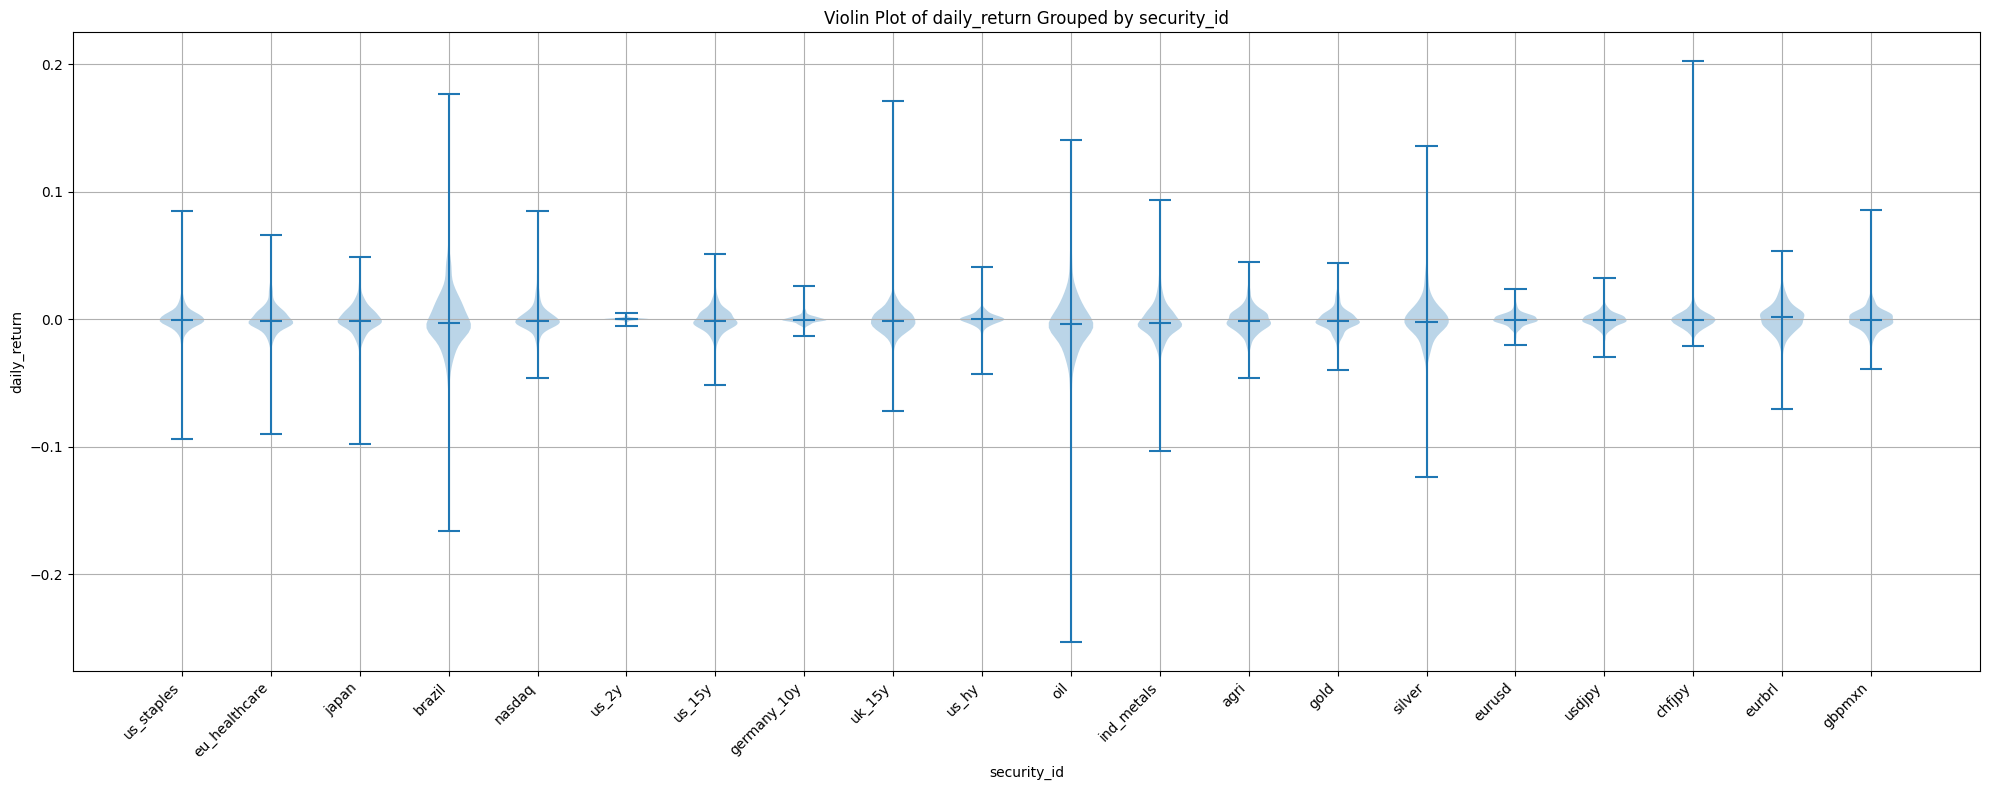

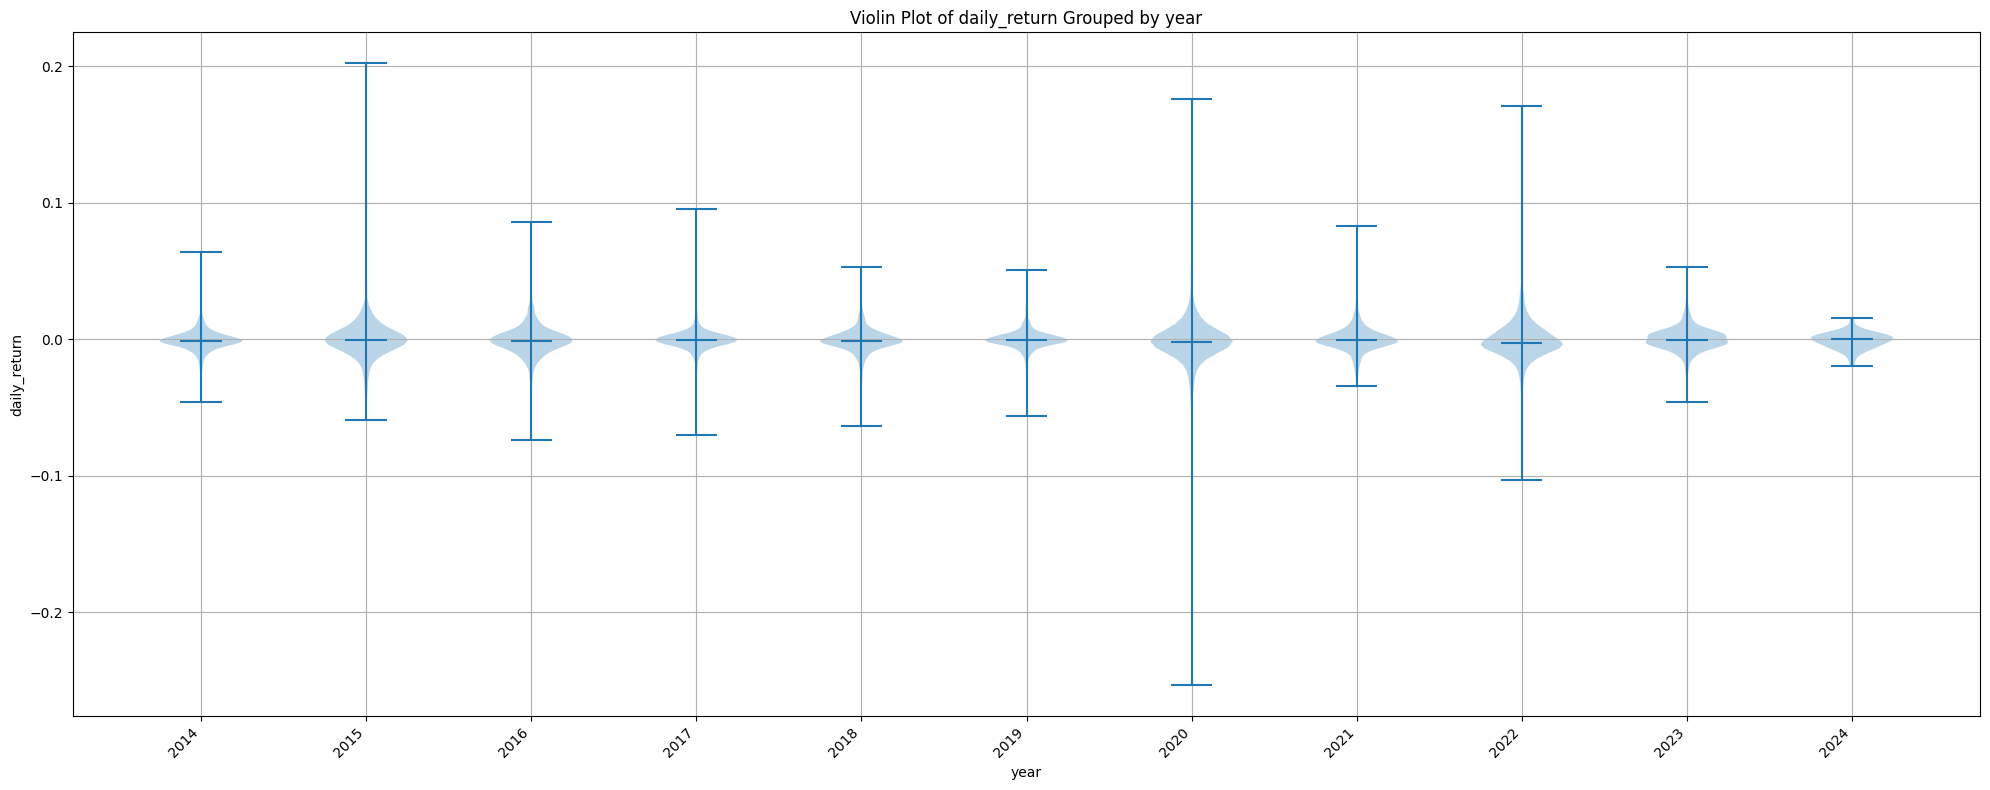

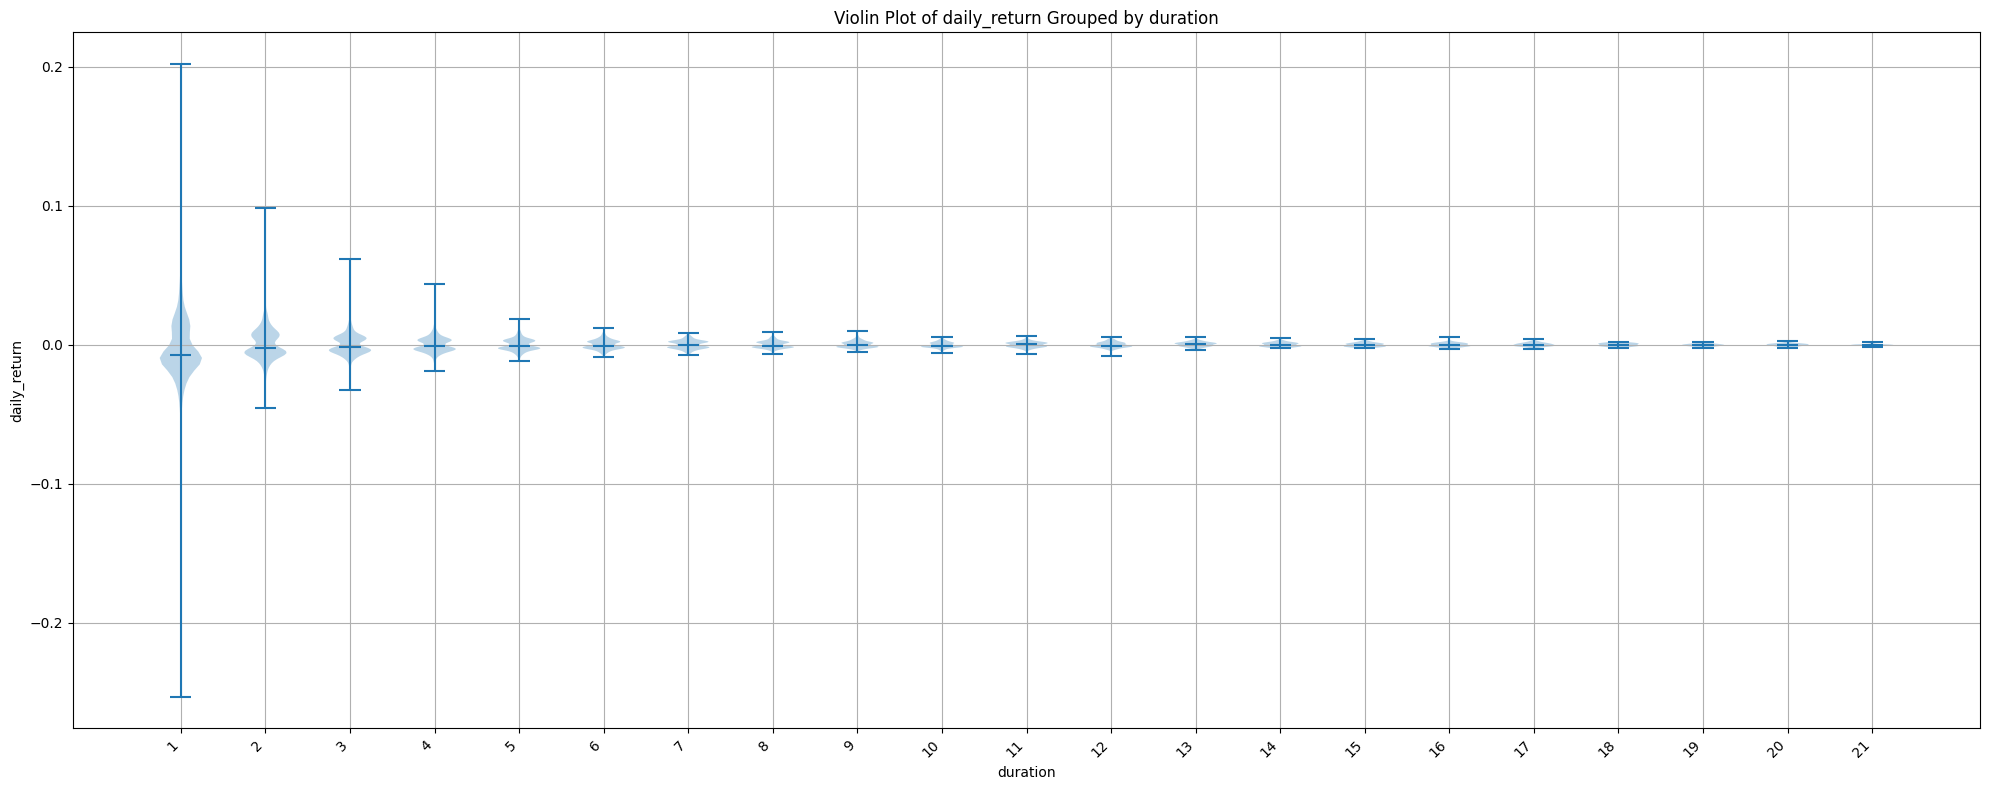

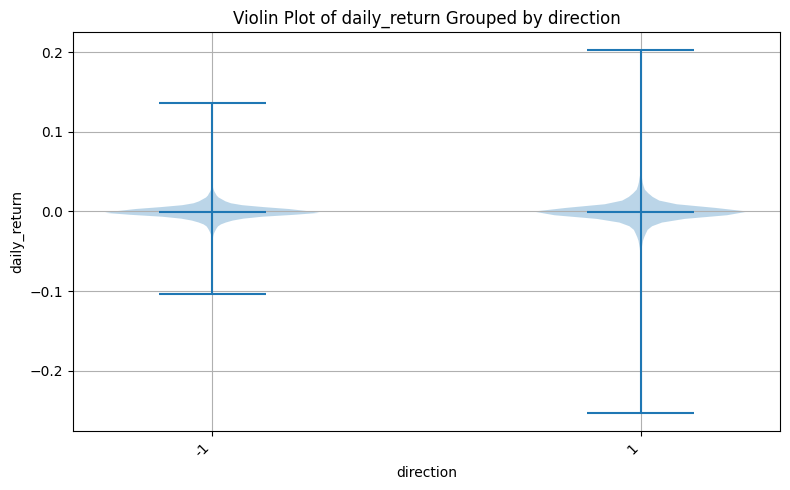

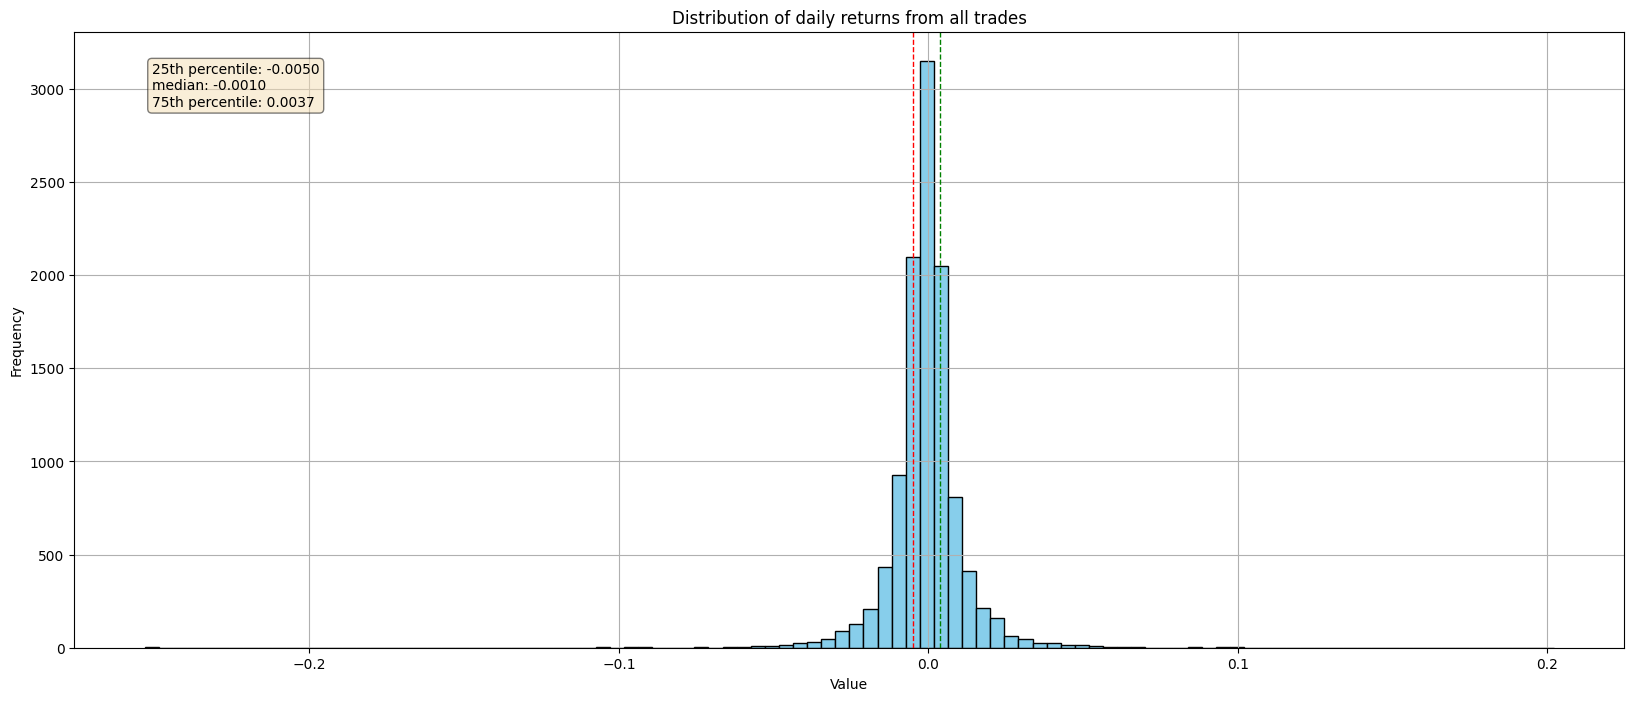

5th percentile: -0.017


In [6]:
violin_plot_grouped(trades_list, 'security_id', 'daily_return')
violin_plot_grouped(trades_list, 'year', 'daily_return')
violin_plot_grouped(trades_list.sort_values(by='duration'), 'duration', 'daily_return')
violin_plot_grouped(trades_list, 'direction', 'daily_return', figsize=(8,5))
plot_histogram(trades_list['daily_return'], 'Distribution of daily returns from all trades', figsize=(20, 8), bins=100)
trades_list.groupby('security_id')['daily_return'].describe()
print('5th percentile:', round(trades_list['daily_return'].quantile(0.05), 4))

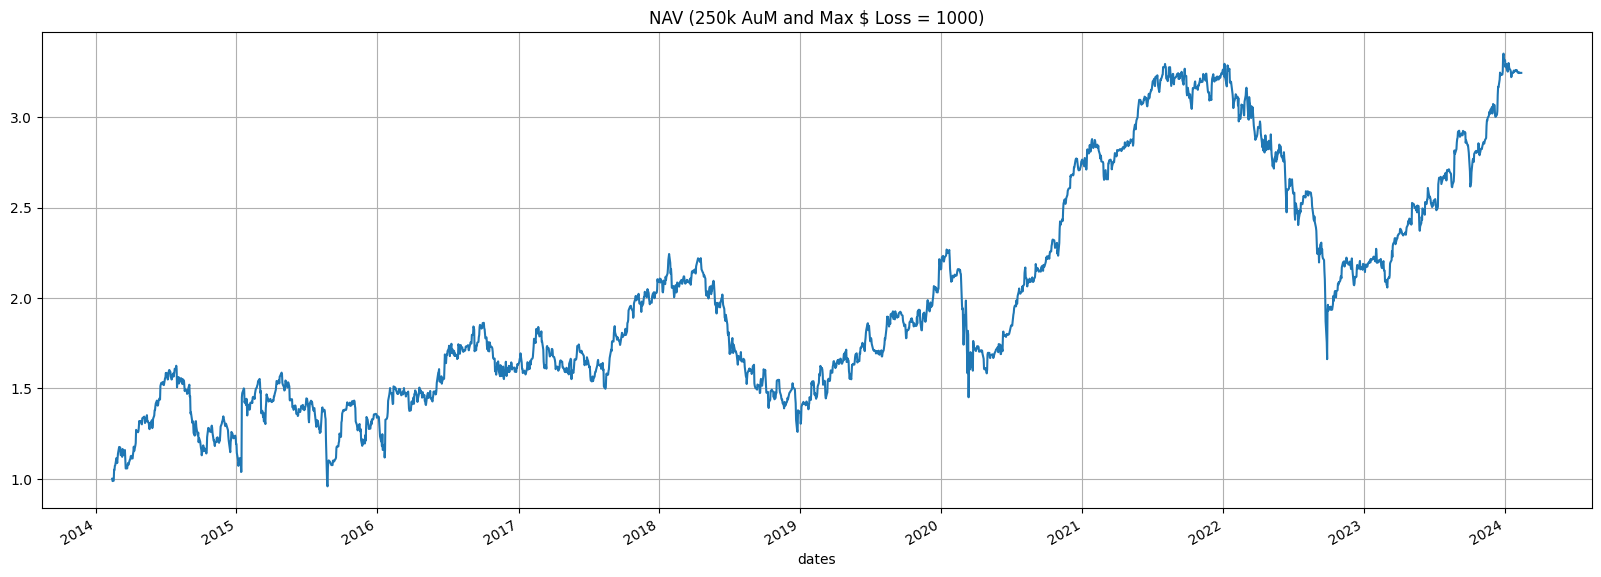

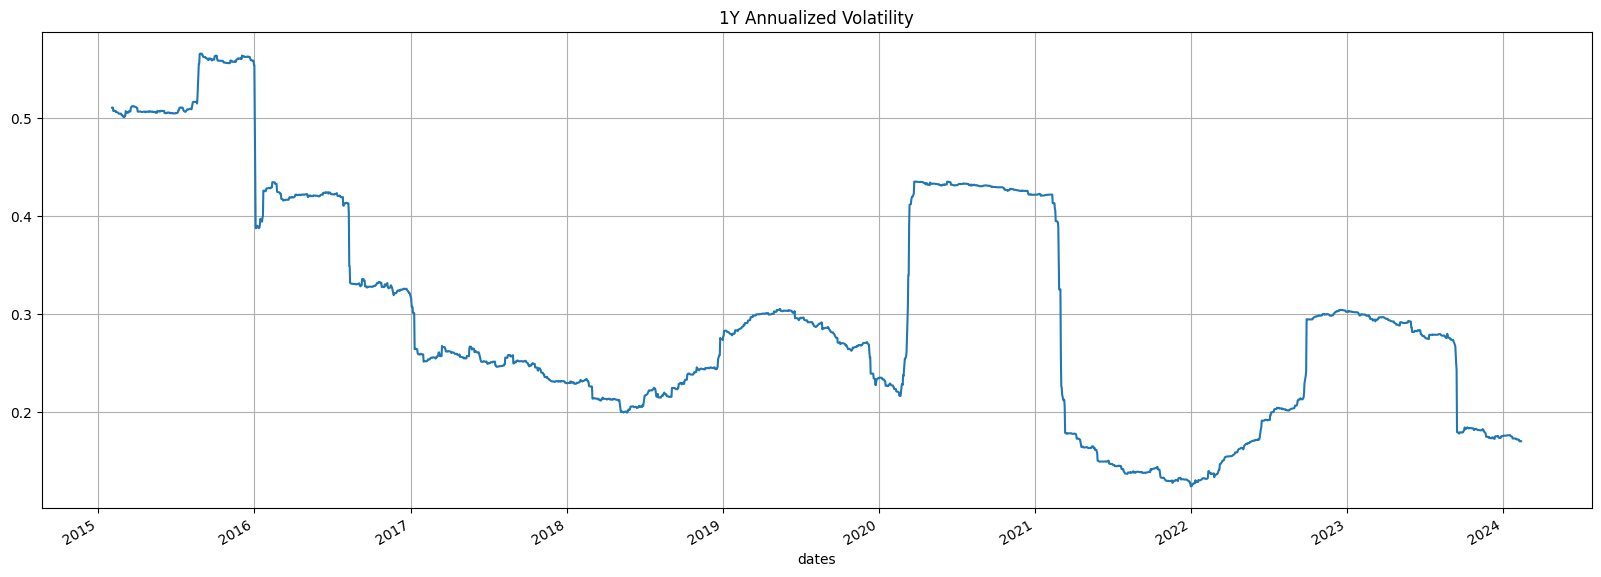

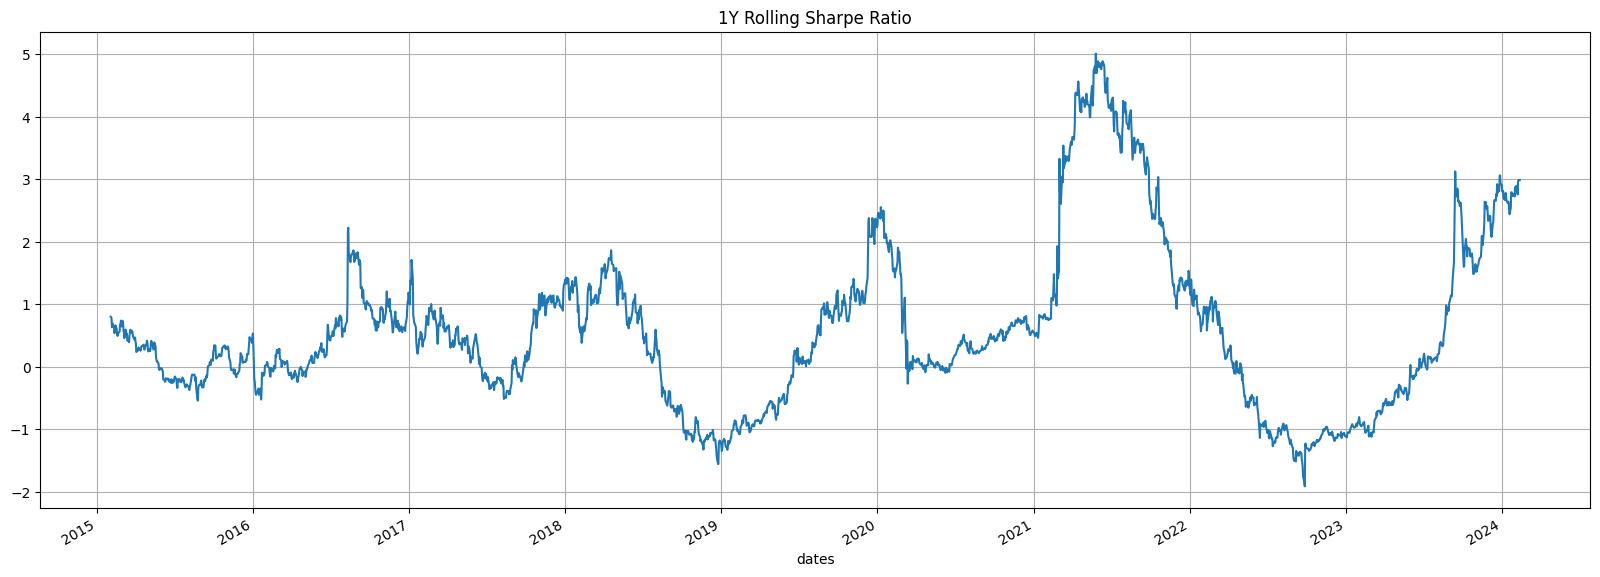

In [7]:
nav = portfolio_nav(trades_pnl, 250000)

(nav.pct_change().fillna(0)+1).cumprod().plot(title='NAV (250k AuM and Max $ Loss = 1000)', figsize=(20,7), grid=True)
plt.show()
(nav.pct_change().rolling(252).std()*252**0.5).plot(figsize=(20,7), grid=True, title='1Y Annualized Volatility')
plt.show()
(nav.pct_change(252) / 
(nav.pct_change().rolling(252).std()*252**0.5)).plot(figsize=(20,7), grid=True, title='1Y Rolling Sharpe Ratio')
plt.show()

In [8]:
print('Portfolio Sharpe Ratio:', strategy_sharpe)

Portfolio Sharpe Ratio: 0.8325028059984432


### Improved Strategy

In [9]:
# STRATEGY PARAMETERS
TRADED_SECURITIES = [
            'us_staples', 'eu_healthcare', 'japan', 'brazil', 'nasdaq', 'us_2y',
            'us_15y', 'germany_10y', 'uk_15y', 'us_hy', 'oil', 'ind_metals', 'agri',
            'gold', 'silver', 'eurusd', 'usdjpy', 'chfjpy', 'eurbrl', 'gbpmxn'
    ]

LONG_PARAMS = {5: 0.1, 10: 0.2, 15: 0.3}
SHORT_PARAMS = {10: 0.9, 21: 0.8, 63: 0.7}
MA_FAST_WDW = 40
MA_SLOW_WDW = 50

SUPPORTIVE_PCTL_MOVE = 0.3
COUNTER_PCTL_MOVE = 0.2
TRADES_MAX_DAYS = 21

MAX_DOLLAR_LOSS = 1000


SIGMA_WDW = 63
GAMMA = None

In [10]:
trades_list_new, trades_pnl_new = run_bt_pipeline(df,
            TRADED_SECURITIES,
            LONG_PARAMS,
            SHORT_PARAMS,
            MA_FAST_WDW,
            MA_SLOW_WDW,
            SUPPORTIVE_PCTL_MOVE,
            COUNTER_PCTL_MOVE,
            TRADES_MAX_DAYS,
            MAX_DOLLAR_LOSS,
            SIGMA_WDW,
            GAMMA,
            )

strategy_sharpe_new = (trades_list['sharpe_ratio']*trades_list['weight']).sum()

100%|██████████| 20/20 [01:12<00:00,  3.61s/it]


In [11]:
print('Number of trades:', len(trades_list_new))

Number of trades: 13828


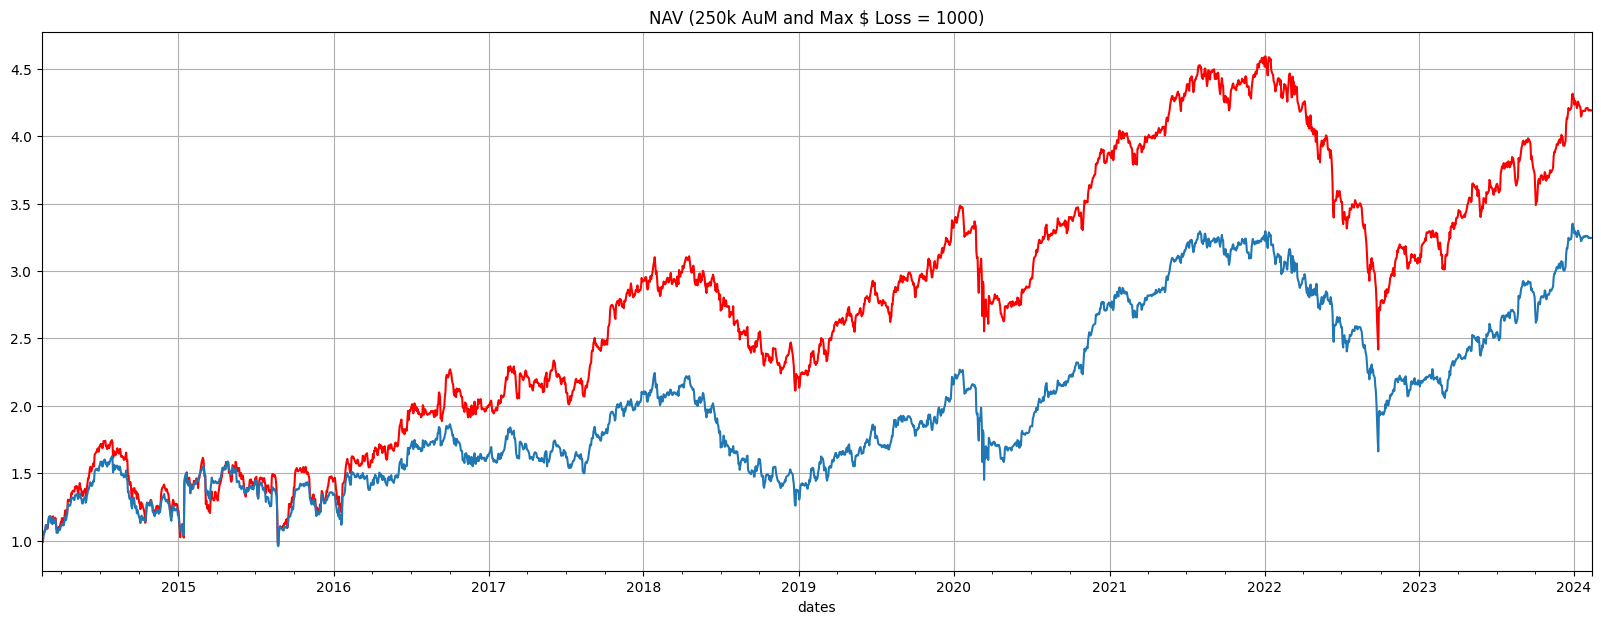

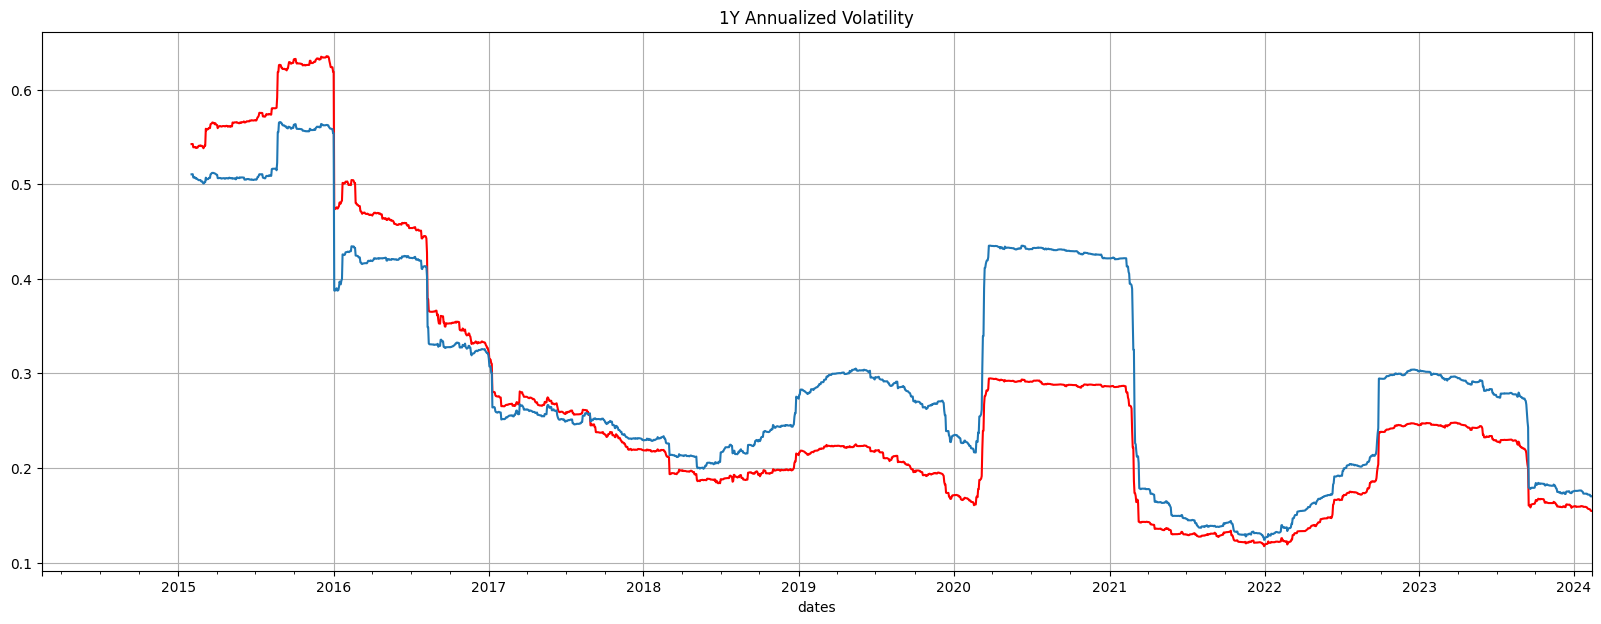

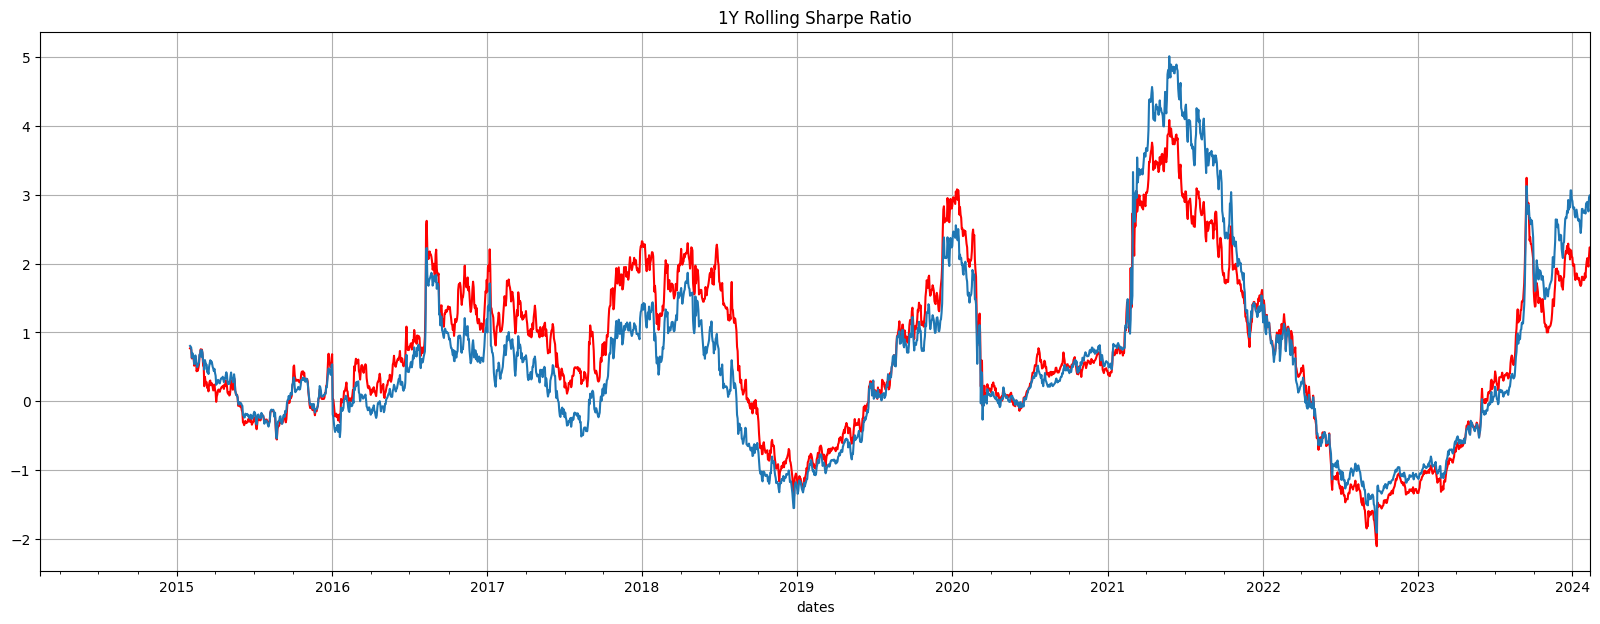

In [12]:
nav_new = portfolio_nav(trades_pnl_new, 250000)

(nav_new.pct_change().fillna(0)+1).cumprod().plot(title='NAV (250k AuM and Max $ Loss = 1000)', figsize=(20,7), grid=True, color='red')
(nav.pct_change().fillna(0)+1).cumprod().plot(title='NAV (250k AuM and Max $ Loss = 1000)', figsize=(20,7), grid=True)
plt.show()
(nav_new.pct_change().rolling(252).std()*252**0.5).plot(figsize=(20,7), grid=True, title='1Y Annualized Volatility', color='red')
(nav.pct_change().rolling(252).std()*252**0.5).plot(figsize=(20,7), grid=True, title='1Y Annualized Volatility')
plt.show()
(nav_new.pct_change(252) / 
(nav_new.pct_change().rolling(252).std()*252**0.5)).plot(figsize=(20,7), grid=True, title='1Y Rolling Sharpe Ratio', color='red')
(nav.pct_change(252) / 
(nav.pct_change().rolling(252).std()*252**0.5)).plot(figsize=(20,7), grid=True, title='1Y Rolling Sharpe Ratio')
plt.show()

<Axes: title={'center': '1Y Rolling Returns'}, xlabel='dates'>

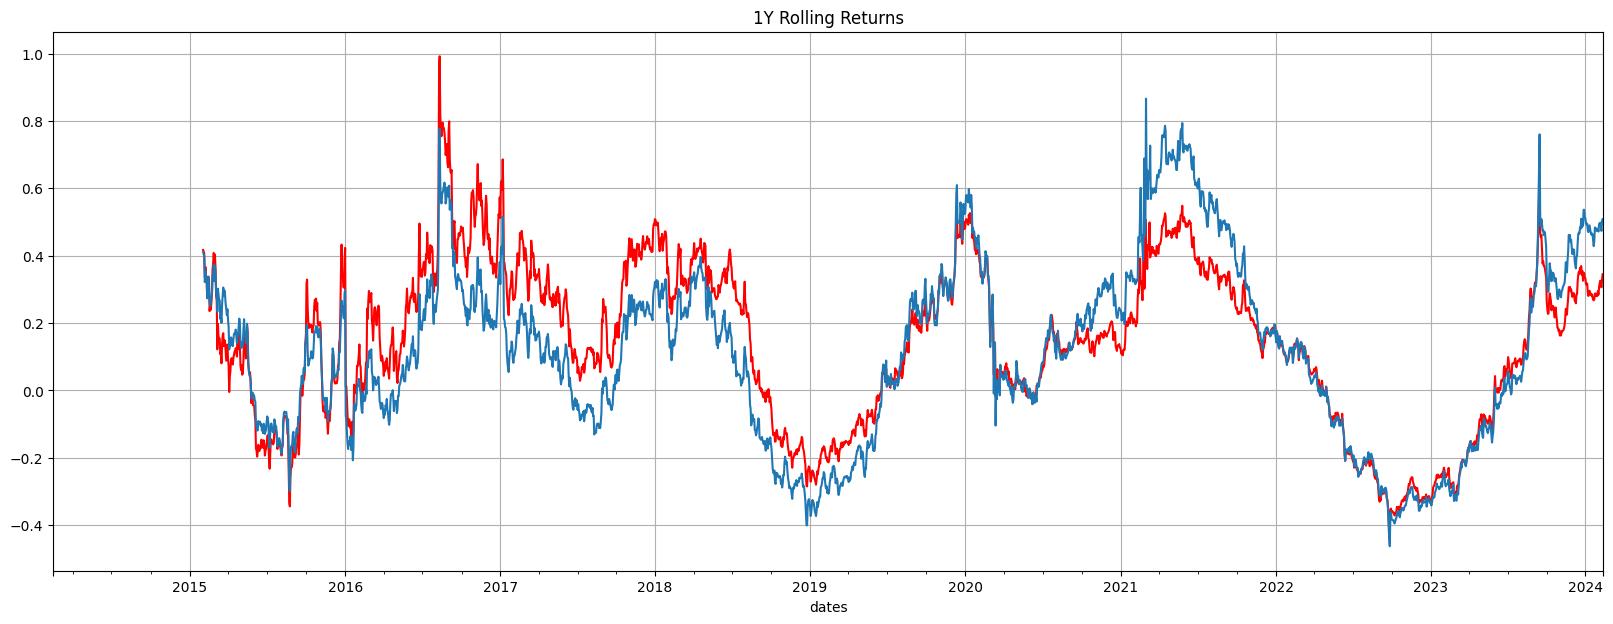

In [13]:
(nav_new.pct_change().fillna(0)+1).cumprod().pct_change(252).plot(color='red')
(nav.pct_change().fillna(0)+1).cumprod().pct_change(252).plot(figsize=(20,7), grid=True, title='1Y Rolling Returns')

### Grid Search

In [ ]:
# Grid search for strategy optimal paramenters

GS_long_pctle = [{10:0.1, 21:0.2, 63:0.3},
                 {5:0.1, 10:0.2, 15:0.3},
                 {20:0.1, 40:0.2, 70:0.3}]

GS_short_pctle = [{10:1-0.1, 21:1-0.2, 63:1-0.3},
                 {5:1-0.1, 10:1-0.2, 15:1-0.3},
                 {20:1-0.1, 40:1-0.2, 70:1-0.3}]

GS_ma_fast = [10, 20, 30, 40]
GS_ma_slow = [50, 65, 80, 90]

# cartesian product of all parameters
GS_PARAMS = list(itertools.product(GS_long_pctle, GS_short_pctle, GS_ma_fast, GS_ma_slow))


# This part of the code computes the Grid Search, it is slow and results are saved in 'GS_Sharpe_2024-02-24 22:34.csv'
sharpe_gs_ptf = {}
idx_gs = 0

for gsp in GS_PARAMS:
    trades_list, trades_pnl = run_bt_pipeline(TRADED_SECURITIES,
            gsp[0],
            gsp[1],
            gsp[2],
            gsp[3],
            SUPPORTIVE_PCTL_MOVE,
            COUNTER_PCTL_MOVE,
            TRADES_MAX_DAYS,
            MAX_DOLLAR_LOSS,
            SIGMA_WDW,
            GAMMA,
            )
    
    sharpe_gs_ptf[idx_gs] = (trades_list['sharpe_ratio']*trades_list['weight']).sum()
    idx_gs +=1
    print(idx_gs)


sharpe_gs_ptf = pd.DataFrame(sharpe_gs_ptf, index=['sharpe_gs']).T

sharpe_gs_ptf

In [ ]:
GS_PARAMS[sharpe_gs_ptf.index[0]] # params of the best model